In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from matplotlib import cm


# Practical 10: Support Vector Machines
**Support vector machines (SVMs)** are a set of supervised learning
methods used for classification,
regression and outliers detection.

The advantages of support vector machines are:

 -   Effective in high dimensional spaces.
 -   Still effective in cases where number of dimensions is greater
     than the number of samples.
 -   Uses a subset of training points in the decision function (called
     support vectors), so it is also memory efficient.
 -   Versatile: different svm\_kernels can be specified for the
     decision function. Common kernels are provided, but it is also
     possible to specify custom kernels.

The disadvantages of support vector machines include:

 -   If the number of features is much greater than the number of
     samples, avoid over-fitting in choosing svm\_kernels and
     regularization term is crucial.
 -   SVMs do not directly provide probability estimates, these are
     calculated using an expensive five-fold cross-validation .
     
SVC implements the "one-versus-one" approach for multi-class
classification. In total, `n_classes * (n_classes - 1) / 2` classifiers
are constructed and each one trains data from two classes. To provide a
consistent interface with other classifiers, the
`decision_function_shape` option allows to monotonically transform the
results of the "one-versus-one" classifiers to a "one-vs-rest" decision
function of shape `(n_samples, n_classes)`.

    >>> X = [[0], [1], [2], [3]]
    >>> Y = [0, 1, 2, 3]
    >>> clf = svm.SVC(decision_function_shape='ovo')
    >>> clf.fit(X, Y)
    SVC(decision_function_shape='ovo')
    >>> dec = clf.decision_function([[1]])
    >>> dec.shape[1] # 4 classes: 4*3/2 = 6
    6
    >>> clf.decision_function_shape = "ovr"
    >>> dec = clf.decision_function([[1]])
    >>> dec.shape[1] # 4 classes
    4

## Support Vector Classification
Given training vectors $x_i \in \mathbb{R}^p$, i=1,..., n, in two
classes, and a vector $y \in \{1, -1\}^n$, our goal is to find $w \in
\mathbb{R}^p$ and $b \in \mathbb{R}$ such that the prediction given by
$\text{sign} (w^T\phi(x) + b)$ is correct for most samples.

SVC solves the following primal problem:

$$\min_ {w, b, \zeta} \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i$$
$$\textrm{subject to } \quad y_i (w^T \phi (x_i) + b) \geq 1 - \zeta_i, \quad \zeta_i \geq 0, i=1, ..., n$$

Intuitively, we're trying to maximize the margin (by minimizing
$||w||^2 = w^Tw$), while incurring a penalty when a sample is
misclassified or within the margin boundary. Ideally, the value $y_i
(w^T \phi (x_i) + b)$ would be $\geq 1$ for all samples, which indicates
a perfect prediction. But problems are usually not always perfectly
separable with a hyperplane, so we allow some samples to be at a
distance $\zeta_i$ from their correct margin boundary. The penalty term
C controls the strengh of this penalty, and as a result, acts as an
inverse regularization parameter (see note below).

The dual problem to the primal is

$$\min_{\lambda} \frac{1}{2} \lambda^T Q \lambda - e^T \lambda$$
$$\textrm {subject to } \quad y^T \lambda = 0 \quad 0 \leq \lambda_i \leq C, i=1, \ldots, n$$

or equivalently

$$ \max_\lambda - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \lambda_i \lambda_j y_i y_j \phi(x_i) ^T \phi(x_j) + \sum_{i=1}^{n} \lambda_i $$
$$ \textrm{subject to } \quad \sum_{i=1}^{n} \lambda_i y_i = 0, \quad 0 \leq \lambda_i \leq C, \quad \textrm{for } i = 1, \ldots, n $$

where $e$ is the vector of all ones, and $Q$ is an $n$ by $n$ positive
semidefinite matrix, $Q_{ij} \equiv y_i y_j K(x_i, x_j)$, where
$K(x_i, x_j) = \phi (x_i)^T \phi (x_j)$ is the kernel. The terms
$\lambda_i$ are called the dual coefficients, and they are upper-bounded
by $C$. This dual representation highlights the fact that training
vectors are implicitly mapped into a higher (maybe infinite) dimensional
space by the function $\phi$: see [kernel
trick](https://en.wikipedia.org/wiki/Kernel_method).

Once the optimization problem is solved, the output of
decision\_function for a given sample $x$ becomes:

$$\sum_{i\in SV} y_i \alpha_i K(x_i, x) + b,$$

and the predicted class correspond to its sign. We only need to sum over
the support vectors (i.e. the samples that lie within the margin)
because the dual coefficients $\alpha_i$ are zero for the other samples.

These parameters can be accessed through the attributes `dual_coef_`
which holds the product $y_i \alpha_i$, `support_vectors_` which holds
the support vectors, and `intercept_` which holds the independent term
$b$

## The kernel trick
We ended with the dual formulation of the SVM problem and noticed thatthe input data vectors $x_i$ are represented by the Gram matrix $Q$.  In other words, only inner-products of the input vectors play a role in the dual formulation -- there is no explicit use of $x_i$ or any other function of $x_i$ besides inner-products.  This observation suggests the use of what is known as the "kernel trick" to replace the inner-products by non-linear functions. The common principle of kernel methods is to construct nonlinear variants of linear algorithms by substituting inner-products by nonlinear kernel functions. Under certain conditions this process can be interpreted as mapping of the  original measurement vectors  (so called  ”input  space”)  onto some higher dimensional space (possibly infinitely high) commonly referredto as the ”feature space”.  Mathematically,  the kernel approach is definedas  follows:   let $x_1, \ldots, x_l$ be  vectors  in  the  input  space,  say $\mathbb{R}^n$,  and  consider a mapping $\phi(x) : \mathbb{R}^n \to F$ where $F$ is an inner-product space.  The kernel-trick is to calculate the inner-product in $F$ using a kernel function $k: \mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R}, k(x_i,x_j) = \phi(x_i)^T \phi(x_j)$, while avoiding explicit mappings(evaluation of) $\phi(\cdot)$.

In the lecture, we have already seen a decomposition of the polynomial kernel. For some kernels, we cannot explicitly compute the coordinates in feature space. The radial basis function kernel is such an instance. 

\begin{alignat}{2} 
\exp\left(-\frac{1}{2}\|\mathbf{x} - \mathbf{x'}\|^2\right)
&= \exp \left(\frac{2}{2}\mathbf{x}^\top \mathbf{x'} - \frac{1}{2}\|\mathbf{x}\|^2  - \frac{1}{2}\|\mathbf{x'}\|^2 \right)\\
&= \exp(\mathbf{x}^\top \mathbf{x'}) \exp( - \frac{1}{2}\|\mathbf{x}\|^2) \exp( - \frac{1}{2}\|\mathbf{x'}\|^2) \\
&= \sum_{j=0}^\infty \frac{(\mathbf{x}^\top \mathbf{x'})^j}{j!} \exp\left(-\frac{1}{2}\|\mathbf{x}\|^2\right) \exp\left(-\frac{1}{2}\|\mathbf{x'}\|^2\right)\\
&= \sum_{j=0}^\infty \sum_{\sum n_i=j} 
\exp\left(-\frac{1}{2}\|\mathbf{x}\|^2\right) 
\frac{x_1^{n_1}\cdots x_k^{n_k} }{\sqrt{n_1! \cdots n_k! }} 
\exp\left(-\frac{1}{2}\|\mathbf{x'}\|^2\right) 
\frac{{x'}_1^{n_1}\cdots {x'}_k^{n_k} }{\sqrt{n_1! \cdots n_k! }} 
\end{alignat}

While this looks a bit scary, we don't have to go through this step by step. What's important here to see is that the RBF kernel is a kernel function with an infinite expansion, making it impossible to compute and store the elements into a transformed design matrix. 

# The SVM margin

The plots below illustrate the effect the parameter `C` has
on the separation line. A large value of `C` basically tells
our model that we do not have that much faith in our data's
distribution, and will only consider points close to line
of separation.

A small value of `C` includes more/all the observations, allowing
the margins to be calculated using all the data in the area.

In the following, we will compute the separating hyperplane as 
well as the parallels that pass through the support vectors. 
First, we will transform $w^T x + b = 0$ into the slope-intercept
form:

$$ w_1 x_1 + w_2 x_2 + b = 0$$
$$ x_2 = \underbrace{-\frac{w_1}{w_2}}_a x_1 - \frac{b}{w_2}$$

The second step is to compute the vertical offset of the two 
parallels to the separating hyperplane that passes through the 
support vectors. 


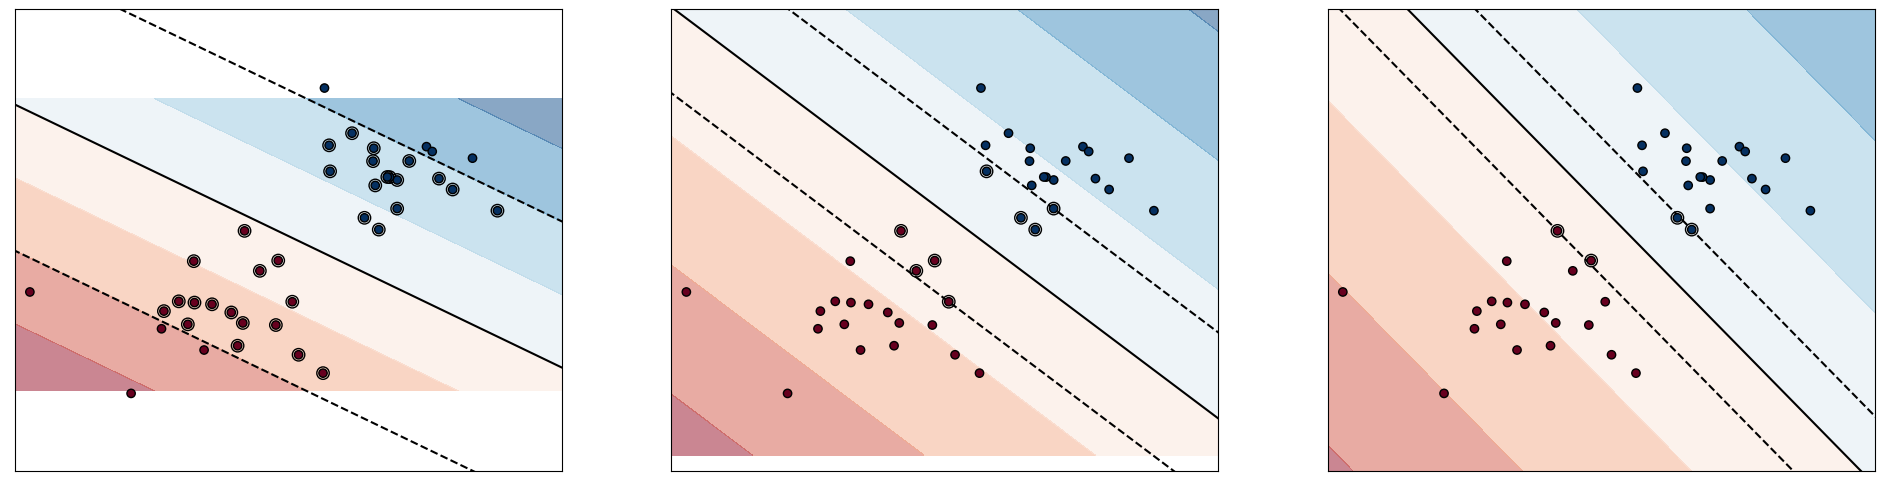

In [2]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

plt.figure(figsize=(4 * 3 * 2, 3 * 2))
for i, C in enumerate([0.005, 0.1, 0.5]):
    clf = svm.SVC(kernel='linear', C=C)
    clf.fit(X, Y)

    # get the separating hyperplane
    w = clf.coef_[0]
    b = clf.intercept_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - b / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors (margin away from hyperplane in direction
    # perpendicular to hyperplane). 
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy - 1 / w[1]
    yy_up = yy + 1 / w[1]
    
    plt.subplot(1, 3, i + 1)

    # plot the line, the points, and the nearest vectors to the plane
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, edgecolors='k',
                cmap=cm.get_cmap('RdBu'))
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=cm.get_cmap('RdBu'),
                edgecolors='k')

    plt.axis('tight')
    x_min = -4.8
    x_max = 4.2
    y_min = -6
    y_max = 6

    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Put the result into a contour plot
    plt.contourf(XX, YY, Z, cmap=cm.get_cmap('RdBu'),
                 alpha=0.5, linestyles=['-'])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())

plt.show()

# Support Vector Machine Kernels

The *kernel function* can be any of the following:

 -   linear: $\langle x, x'\rangle$.
 -   polynomial: $(\gamma \langle x, x'\rangle + r)^d$, where $d$ is
     specified by parameter `degree`, $r$ by `coef0`.
 -   rbf: $\exp(-\gamma \|x-x'\|^2)$, where $\gamma$ is specified by
     parameter `gamma`, must be greater than 0.
 -   sigmoid $\tanh(\gamma \langle x,x'\rangle + r)$, where $r$ is
     specified by `coef0`.

Different kernels are specified by the kernel parameter:

    >>> linear_svc = svm.SVC(kernel='linear')
    >>> linear_svc.kernel
    'linear'
    >>> rbf_svc = svm.SVC(kernel='rbf')
    >>> rbf_svc.kernel
    'rbf'

### Parameters of the RBF Kernel

When training an SVM with the *Radial Basis Function* (RBF) kernel, two
parameters must be considered: `C` and `gamma`. The parameter `C`,
common to all SVM kernels, trades off misclassification of training
examples against simplicity of the decision surface. A low `C` makes the
decision surface smooth, while a high `C` aims at classifying all
training examples correctly. `gamma` defines how much influence a single
training example has. The larger `gamma` is, the closer other examples
must be to be affected.

Proper choice of `C` and `gamma` is critical to the SVM's performance.
One is advised to use \~sklearn.model\_selection.GridSearchCV with `C`
and `gamma` spaced exponentially far apart to choose good values.

## Example 1: 2D Iris Subset with two classes
The following code classifies a subset of the Iris flower dataset. We
ignore samples belonging to class 0 and only use the first two features.
Plots the decision surface, the margin and the decision boundary. 

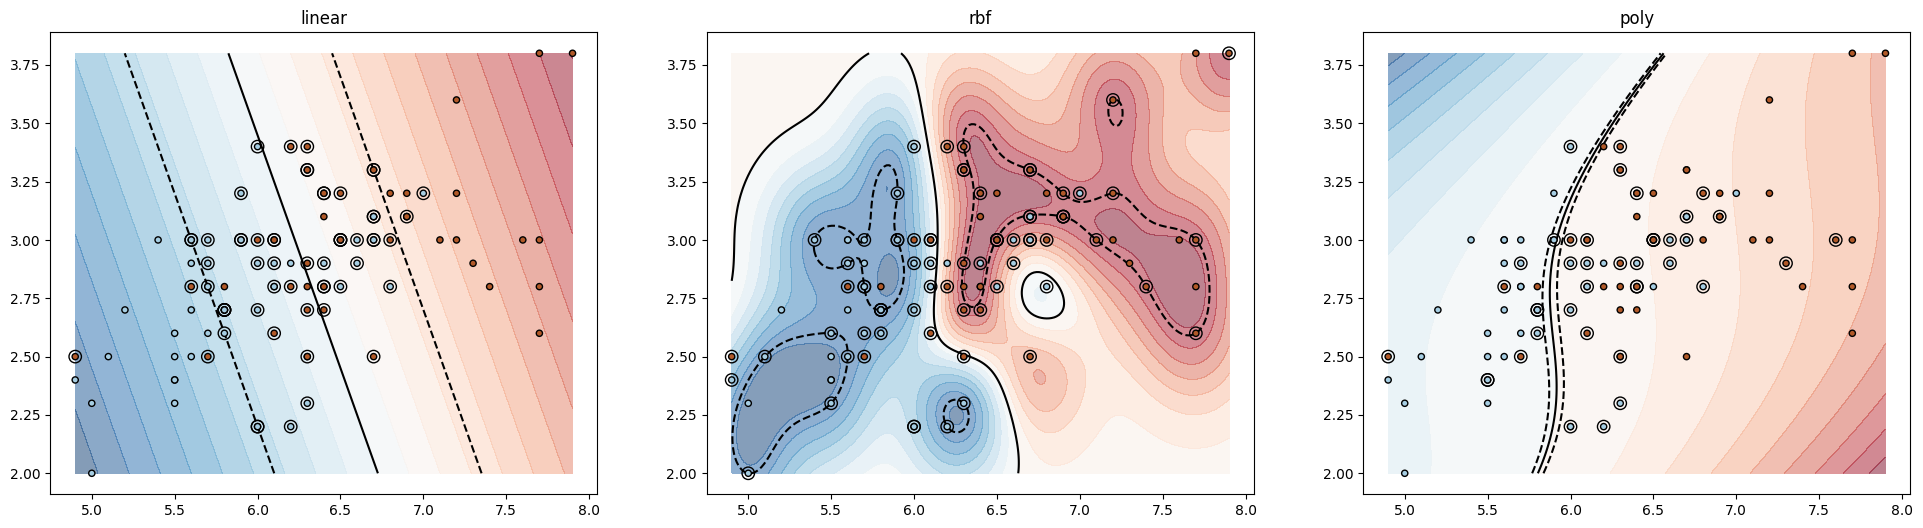

In [3]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 0, :2]
y = y[y != 0]

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(float)

X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

# fit the model
plt.figure(figsize=(4 * 3 * 2, 3 * 2))
for i, kernel in enumerate(('linear', 'rbf', 'poly')):
    clf = svm.SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # support vectors
    svs = clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contourf(XX, YY, Z, cmap=cm.get_cmap('RdBu_r'),
                 alpha=0.5, linestyles=['-'], levels=20)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-1, 0, 1])

    plt.title(kernel)
plt.show()

## Example 2: Full Iris dataset with the first two features
The following code classifies the full Iris flower dataset using only the first two features.
Plots the decision boundaries. 

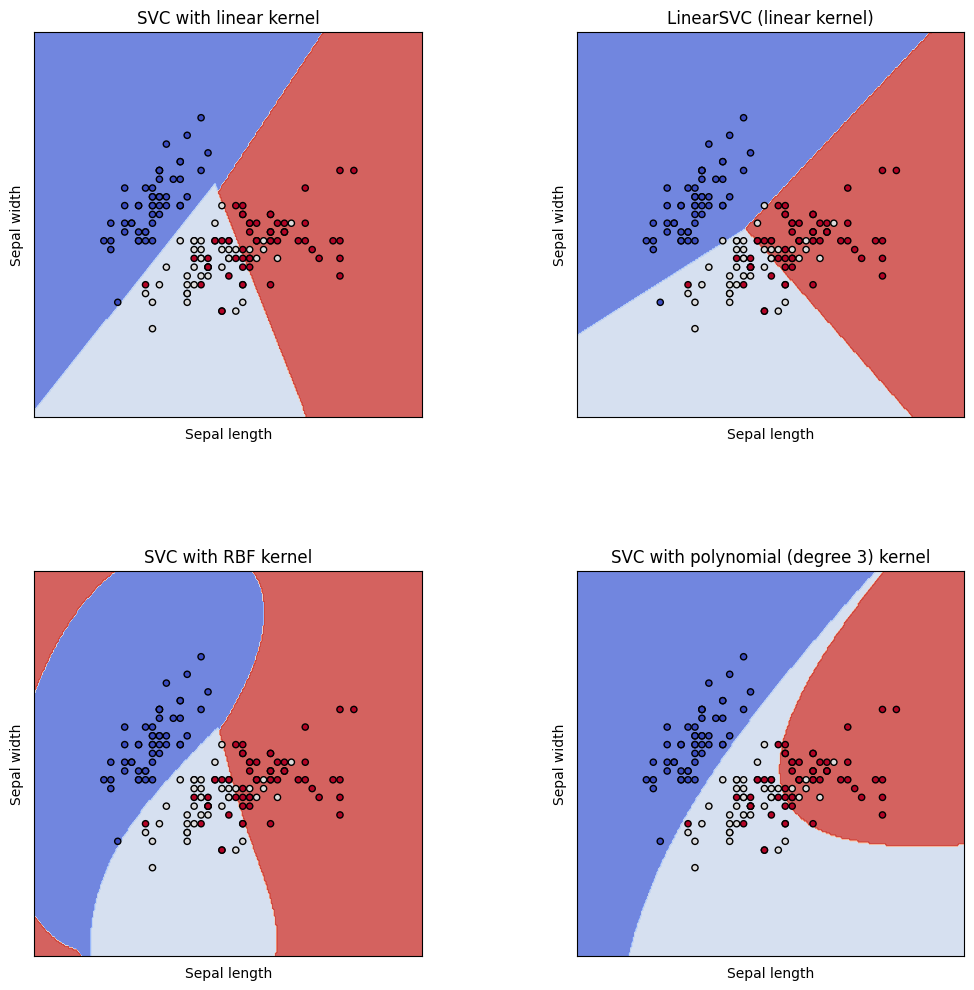

In [4]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2, figsize=(4 * 3, 4 * 3))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()


# RBF SVM parameters

This example illustrates the effect of the parameters ``gamma`` and ``C`` of
the Radial Basis Function (RBF) kernel SVM.

Intuitively, the ``gamma`` parameter defines how far the influence of a single
training example reaches, with low values meaning 'far' and high values meaning
'close'. The ``gamma`` parameters can be seen as the inverse of the radius of
influence of samples selected by the model as support vectors.

The ``C`` parameter trades off correct classification of training examples
against maximization of the decision function's margin. For larger values of
``C``, a smaller margin will be accepted if the decision function is better at
classifying all training points correctly. A lower ``C`` will encourage a
larger margin, therefore a simpler decision function, at the cost of training
accuracy. In other words ``C`` behaves as a regularization parameter in the
SVM.

The first plot is a visualization of the decision function for a variety of
parameter values on a simplified classification problem involving only 2 input
features and 2 possible target classes (binary classification). Note that this
kind of plot is not possible to do for problems with more features or target
classes.

The second plot is a heatmap of the classifier's cross-validation accuracy as a
function of ``C`` and ``gamma``. For this example we explore a relatively large
grid for illustration purposes. In practice, a logarithmic grid from
$10^{-3}$ to $10^3$ is usually sufficient. If the best parameters
lie on the boundaries of the grid, it can be extended in that direction in a
subsequent search.

Note that the heat map plot has a special colorbar with a midpoint value close
to the score values of the best performing models so as to make it easy to tell
them apart in the blink of an eye.

The behavior of the model is very sensitive to the ``gamma`` parameter. If
``gamma`` is too large, the radius of the area of influence of the support
vectors only includes the support vector itself and no amount of
regularization with ``C`` will be able to prevent overfitting.

When ``gamma`` is very small, the model is too constrained and cannot capture
the complexity or "shape" of the data. The region of influence of any selected
support vector would include the whole training set. The resulting model will
behave similarly to a linear model with a set of hyperplanes that separate the
centers of high density of any pair of two classes.

For intermediate values, we can see on the second plot that good models can
be found on a diagonal of ``C`` and ``gamma``. Smooth models (lower ``gamma``
values) can be made more complex by increasing the importance of classifying
each point correctly (larger ``C`` values) hence the diagonal of good
performing models.

Finally, one can also observe that for some intermediate values of ``gamma`` we
get equally performing models when ``C`` becomes very large. This suggests that
the set of support vectors does not change anymore. The radius of the RBF
kernel alone acts as a good structural regularizer. Increasing ``C`` further
doesn't help, likely because there are no more training points in violation
(inside the margin or wrongly classified), or at least no better solution can
be found. Scores being equal, it may make sense to use the smaller ``C``
values, since very high ``C`` values typically increase fitting time.

On the other hand, lower ``C`` values generally lead to more support vectors,
which may increase prediction time. Therefore, lowering the value of ``C``
involves a trade-off between fitting time and prediction time.

We should also note that small differences in scores results from the random
splits of the cross-validation procedure. Those spurious variations can be
smoothed out by increasing the number of CV iterations ``n_splits`` at the
expense of compute time. Increasing the value number of ``C_range`` and
``gamma_range`` steps will increase the resolution of the hyper-parameter heat
map.


Automatically created module for IPython interactive environment
The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.97


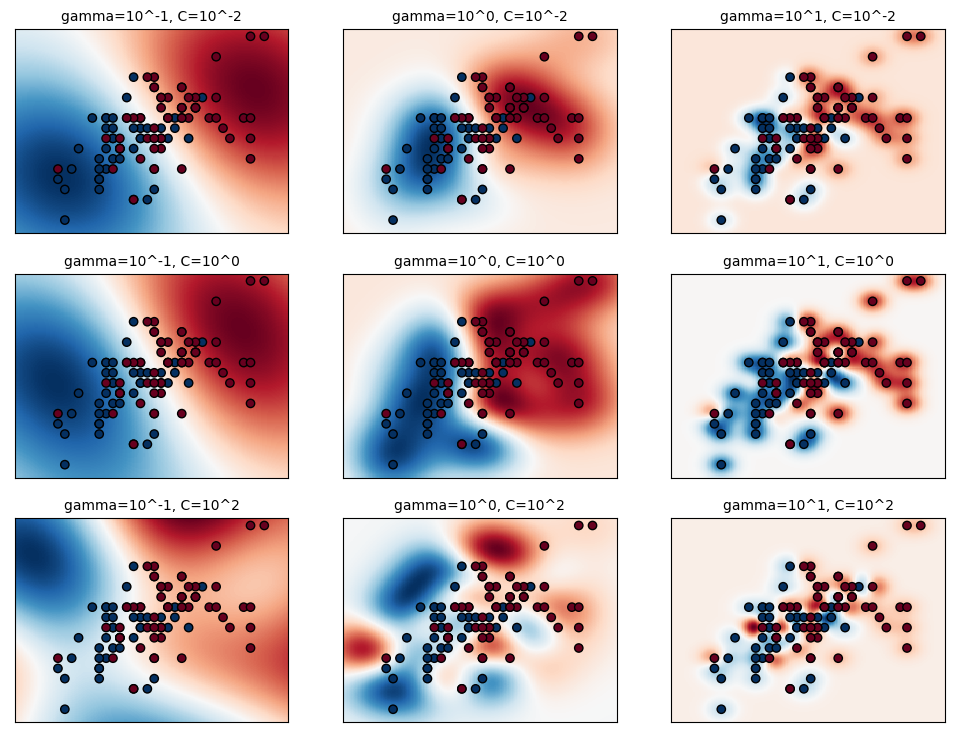

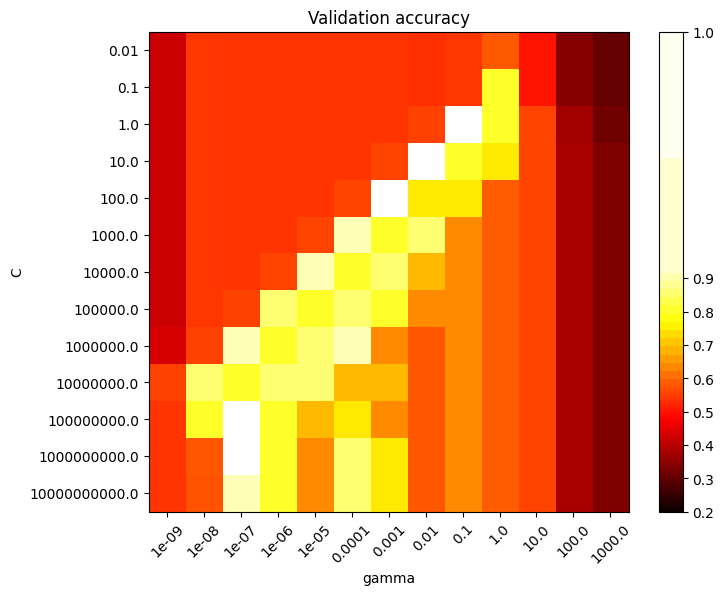

In [5]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# #############################################################################
# Load and prepare data set
#
# dataset for grid search

iris = load_iris()
X = iris.data
y = iris.target

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

# #############################################################################
# Visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(4 * 3, 3 * 3))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()